In [ ]:
import torch
import time
import matplotlib.pyplot as plt
import non_local_boxes
from IPython.display import clear_output   # in order to clear the print output

# Sugar coating for reloading
%matplotlib inline
%load_ext autoreload
%autoreload 2

# Gradient Descent

In [ ]:
M1 = torch.zeros(32, 32)
for i in range(32):
    M1[i,i]=1
M1[0,0]=0.5
M1[0,1]=0.5
M1[1,0]=0.5
M1[1,1]=0.5

M2 = torch.zeros(32, 32)
for i in range(32):
    M2[i,i]=1
M2[8,8]=0.5
M2[8,9]=0.5
M2[9,8]=0.5
M2[9,9]=0.5

M3 = torch.zeros(32, 32)
for i in range(32):
    M3[i,i]=1
M3[2,2]=0.5
M3[2,3]=0.5
M3[3,2]=0.5
M3[3,3]=0.5

M4 = torch.zeros(32, 32)
for i in range(32):
    M4[i,i]=1
M4[10,10]=0.5
M4[10,11]=0.5
M4[11,10]=0.5
M4[11,11]=0.5

M5 = torch.zeros(32, 32)
for i in range(32):
    M5[i,i]=1
M5[4,4]=0.5
M5[4,5]=0.5
M5[5,4]=0.5
M5[5,5]=0.5

M6 = torch.zeros(32, 32)
for i in range(32):
    M6[i,i]=1
M6[12,12]=0.5
M6[12,13]=0.5
M6[13,12]=0.5
M6[13,13]=0.5

M7 = torch.zeros(32, 32)
for i in range(32):
    M7[i,i]=1
M7[6,6]=0.5
M7[6,7]=0.5
M7[7,6]=0.5
M7[7,7]=0.5

M8 = torch.zeros(32, 32)
for i in range(32):
    M8[i,i]=1
M8[14,14]=0.5
M8[14,15]=0.5
M8[15,14]=0.5
M8[15,15]=0.5

In [ ]:
def projected_wiring(W):  # W is a 32xn tensor
    W = torch.maximum(W, torch.zeros_like(W))  # it outputs the element-wise maximum
    W = torch.minimum(W, torch.ones_like(W))   # similarly for minimum

    T1 = (torch.abs(W[0,:]-W[1,:]) <= torch.abs(W[8, :] - W[9, :]))
    W = T1*torch.tensordot(M1, W, dims=1) + torch.logical_not(T1)*torch.tensordot(M2, W, dims=1)
    
    T2 = (torch.abs(W[2,:]-W[3,:]) <= torch.abs(W[10, :] - W[11, :]))
    W = T2*torch.tensordot(M3, W, dims=1) + torch.logical_not(T2)*torch.tensordot(M4, W, dims=1)

    T3 = (torch.abs(W[4,:]-W[5,:]) <= torch.abs(W[12, :] - W[13, :]))
    W = T3*torch.tensordot(M5, W, dims=1) + torch.logical_not(T3)*torch.tensordot(M6, W, dims=1)

    T4 = (torch.abs(W[6,:]-W[7,:]) <= torch.abs(W[14, :] - W[15, :]))
    W = T4*torch.tensordot(M7, W, dims=1) + torch.logical_not(T4)*torch.tensordot(M8, W, dims=1)

    return W

In [ ]:
def gradient_descent(starting_W, P, Q, learning_rate = 2, nb_iterations = 20):
    external_grad = torch.ones(non_local_boxes.evaluate.nb_columns)
    W = starting_W
    for i in range(nb_iterations):
        non_local_boxes.evaluate.phi_flat(W, P, Q).backward(gradient=external_grad)
        W = projected_wiring(W + learning_rate*W.grad).detach()  # create a brand new tensor, forgeting the previous gradient
        W.requires_grad=True
    return W

# Test in some triangle

In [ ]:
def new_color(value, threshold, k, max_box_power_GD):
    if value > threshold:
        return (0, 0.1*(1-k/max_box_power_GD)+1*(k/max_box_power_GD), 0.1*(1-k/max_box_power_GD)+1*(k/max_box_power_GD))
    return "orangered"

In [ ]:
def next_Q(Q, P, W0, color_point, k, max_box_power_GD, learning_rate, nb_iterations, threshold): # Q is a 2x2x2x2 tensor
    if color_point == "orangered":
        W = gradient_descent(W0, non_local_boxes.utils.tensor_to_matrix(Q), P, learning_rate, nb_iterations)
        list = non_local_boxes.evaluate.phi_flat(W, non_local_boxes.utils.tensor_to_matrix(Q), P).detach().numpy()
        index, value = max(enumerate(list), key=lambda x: x[1])  # find the best value in list
        best_wiring = W[:,index].detach()
        best_wiring = torch.t(best_wiring.repeat(non_local_boxes.evaluate.nb_columns, 1))
        new_Q = non_local_boxes.evaluate.R(best_wiring, non_local_boxes.utils.tensor_to_matrix(Q), P)[:,:,:,:,0]
        color_point = new_color(value, threshold, k, max_box_power_GD)
        print(value)
        best_wiring.requires_grad = True
    else:
        new_Q = Q
        best_wiring = W0
    return new_Q, best_wiring, color_point

In [ ]:
def test_box_power(Q, P, W0, n, color_point, k, max_box_power_GD, max_box_power, learning_rate, nb_iterations, threshold): # Q is a 2x2x2x2 tensor
    for l in range(max_box_power):
        if color_point != "orangered":
            break
        Q=non_local_boxes.evaluate.R(W0, non_local_boxes.utils.tensor_to_matrix(Q), P)[:,:,:,:,0]
        value = float(non_local_boxes.evaluate.h_flat(Q))
        color_point = new_color(value, threshold, k, max_box_power_GD)

    return color_point

In [ ]:
def draw_triangle(Box1, Box1_name, Box2, Box2_name, Box3, Box3_name, box_grid_size, max_box_power_GD, max_box_power, learning_rate, nb_iterations, threshold): # Box is a 4x4 tensor
    X = torch.tensor([[1,3], [4,1], [4, 5]]).numpy()
    triangle = plt.Polygon(X[:3,:], color="snow")
    plt.gca().add_patch(triangle)

    n = non_local_boxes.evaluate.nb_columns

    for i in range(box_grid_size+1):
        for j in range(box_grid_size-i+1):
            alpha, beta = i/box_grid_size, j/box_grid_size
            P = alpha*Box1 + beta*Box2 + (1-alpha-beta)*Box3   # P is a 4x4 matrix
            color_point = "orangered"

            Q=non_local_boxes.utils.matrix_to_tensor(torch.clone(P))  # Q is a 2x2x2x2 tensor 
            value = float(non_local_boxes.evaluate.h_flat(Q))
            color_point = new_color(value, threshold, 0, max_box_power_GD)
            best_wiring = non_local_boxes.utils.random_wiring(n)

            for k in range(max_box_power_GD-1):
                Q, best_wiring, color_point = next_Q(Q, P, best_wiring, color_point, k+1, max_box_power_GD, learning_rate, nb_iterations, threshold)
                color_point = test_box_power(Q, P, best_wiring, n, color_point, k+1, max_box_power_GD, max_box_power, learning_rate, nb_iterations, threshold)

            plt.plot(X[0,0]*alpha + X[1,0]*beta + X[2,0]*(1-alpha-beta), X[0,1]*alpha + X[1,1]*beta + X[2,1]*(1-alpha-beta), 'o', markersize=3, color=color_point)
                    
    plt.text(X[0,0], X[0,1]+0.1, Box1_name, horizontalalignment='center')
    plt.text(X[1,0]+0.1, X[1,1], Box2_name, verticalalignment='center')
    plt.text(X[2,0]+0.1, X[2,1], Box3_name, verticalalignment='center')
    plt.show()

In [ ]:
"""draw_triangle(
    Box1=non_local_boxes.utils.PR,
    Box1_name = "PR",
    Box2=non_local_boxes.utils.P_0,
    Box2_name = "P0",
    Box3 = non_local_boxes.utils.P_1,
    Box3_name = "P1",
    box_grid_size = 40,
    max_box_power_GD = 2,
    max_box_power = 50,
    learning_rate = 2,
    nb_iterations = 40,
    threshold = (3 + float(torch.sqrt(torch.tensor(6))))/6
)"""

# Naive test in some triangle

In [ ]:
def draw_triangle_naive(Box1, Box1_name, Box2, Box2_name, Box3, Box3_name, box_grid_size, max_box_power, learning_rate, nb_iterations, threshold): # P is a 4x4 tensor
    X = torch.tensor([[1,3], [4,1], [4, 5]]).numpy()
    triangle = plt.Polygon(X[:3,:], color="snow")
    plt.gca().add_patch(triangle)

    n = non_local_boxes.evaluate.nb_columns
    W_random = non_local_boxes.utils.random_wiring(n)

    for i in range(box_grid_size+1):
        for j in range(box_grid_size-i+1):
            alpha, beta = i/box_grid_size, j/box_grid_size
            P = alpha*Box1 + beta*Box2 + (1-alpha-beta)*Box3   # P is a 4x4 matrix
            color_point = "orangered"

            Q=non_local_boxes.utils.matrix_to_tensor(torch.clone(P))  # Q is a 2x2x2x2 tensor 
            value = float(non_local_boxes.evaluate.h_flat(Q))

            if value > threshold:
                color_point = (0, 0.1, 0.1)
                print(value)
            else:
                # Given a box P, we look for the W maximizing P x_W P
                W = gradient_descent(W_random, P, P, learning_rate=2, nb_iterations=20)
                list = non_local_boxes.evaluate.phi_flat(W, P, P).detach().numpy()
                index, value = max(enumerate(list), key=lambda x: x[1])
                best_wiring = W[:,index].detach()
                best_wiring = torch.t(best_wiring.repeat(non_local_boxes.evaluate.nb_columns, 1))
                print(value)
                
                for k in range(max_box_power+1):
                    if non_local_boxes.evaluate.h_flat(Q)[0] > threshold:
                        color_point = (0, 0.1*(1-k/max_box_power)+1*(k/max_box_power), 0.1*(1-k/max_box_power)+1*(k/max_box_power))
                        break
                    Q=non_local_boxes.evaluate.R(best_wiring, non_local_boxes.utils.tensor_to_matrix(Q), P)[:,:,:,:,0]

            plt.plot(X[0,0]*alpha + X[1,0]*beta + X[2,0]*(1-alpha-beta), X[0,1]*alpha + X[1,1]*beta + X[2,1]*(1-alpha-beta), 'o', markersize=3, color=color_point)
                    
    plt.text(X[0,0], X[0,1]+0.1, Box1_name, horizontalalignment='center')
    plt.text(X[1,0]+0.1, X[1,1], Box2_name, verticalalignment='center')
    plt.text(X[2,0]+0.1, X[2,1], Box3_name, verticalalignment='center')
    plt.show()

In [ ]:
"""draw_triangle_naive(
    Box1=non_local_boxes.utils.PR,
    Box1_name = "PR",
    Box2=non_local_boxes.utils.P_0,
    Box2_name = "P0",
    Box3 = non_local_boxes.utils.P_1,
    Box3_name = "P1",
    box_grid_size = 40,
    max_box_power = 50,
    learning_rate = 2,
    nb_iterations = 40,
    threshold = (3 + float(torch.sqrt(torch.tensor(6))))/6
)"""

# With blue cones: it's dangerous because the triangle is not stable under all wirings

We check if the starting box $P$ is a in the blue cone of another box, but we don't check the powers of $P$ because they could be outside of the triangle.

In [ ]:
def is_in_a_blue_cone(xP, yP, blue_points, X): # It tests if Box located at (x, y) is in the cone of a blue box
    # list is a list of coordinates (x0, y0) such that h(P)<0.91 but P is blue
    for point in blue_points:
        x0, y0 = point
        f = lambda x : X[1,1]*(x-x0)/(X[1,0]-x0) + y0*(x-X[1,0])/(x0-X[1,0])  # Lagrange interpolation
        g = lambda x : X[2,1]*(x-x0)/(X[2,0]-x0) + y0*(x-X[2,0])/(x0-X[2,0])  # Lagrange interpolation
        if yP <= f(xP) and yP >= g(xP):
            return True
    return False

In [ ]:
def new_color_with_blue_cones(value, threshold, blue_points, X, k, xP, yP, max_box_power_GD):
    if value > threshold:
        blue_points.append((xP,yP))
        return blue_points, (0, 0.1*(1-k/max_box_power_GD)+1*(k/max_box_power_GD), 0.1*(1-k/max_box_power_GD)+1*(k/max_box_power_GD))
    return blue_points, "orangered"

In [ ]:
def next_Q_with_blue_cones(Q, P, W0, color_point, k, max_box_power_GD, learning_rate, nb_iterations, threshold, blue_points, X, xP, yP): # Q is a 2x2x2x2 tensor
    if color_point == "orangered":
        W = gradient_descent(W0, non_local_boxes.utils.tensor_to_matrix(Q), P, learning_rate, nb_iterations)
        list = non_local_boxes.evaluate.phi_flat(W, non_local_boxes.utils.tensor_to_matrix(Q), P).detach().numpy()
        index, value = max(enumerate(list), key=lambda x: x[1])  # find the best value in list
        best_wiring = W[:,index].detach()
        best_wiring = torch.t(best_wiring.repeat(non_local_boxes.evaluate.nb_columns, 1))
        new_Q = non_local_boxes.evaluate.R(best_wiring, non_local_boxes.utils.tensor_to_matrix(Q), P)[:,:,:,:,0]
        blue_points, color_point = new_color_with_blue_cones(value, threshold, blue_points, X, k, xP, yP, max_box_power_GD)
        print(value)
        best_wiring.requires_grad = True
    else:
        new_Q = Q
        best_wiring = W0
    return new_Q, best_wiring, blue_points, color_point

In [ ]:
def test_box_power_with_blue_cones(Q, P, W0, n, color_point, k, max_box_power_GD, max_box_power, learning_rate, nb_iterations, threshold, blue_points, X, xP, yP): # Q is a 2x2x2x2 tensor
    Q = torch.clone(Q)
    for l in range(max_box_power):
        if color_point != "orangered":
            break
        Q=non_local_boxes.evaluate.R(W0, non_local_boxes.utils.tensor_to_matrix(Q), P)[:,:,:,:,0]
        value = float(non_local_boxes.evaluate.h_flat(Q))
        blue_points, color_point = new_color_with_blue_cones(value, threshold, blue_points, X, k, xP, yP, max_box_power_GD)

    return blue_points, color_point

In [ ]:
def draw_triangle_with_blue_cones(Box1, Box1_name, Box2, Box2_name, Box3, Box3_name, box_grid_size, max_box_power_GD, max_box_power, learning_rate, nb_iterations, threshold): # P is a 4x4 tensor
    X = torch.tensor([[1,3], [4,1], [4, 5]]).numpy()
    triangle = plt.Polygon(X[:3,:], color="snow")
    plt.gca().add_patch(triangle)

    n = non_local_boxes.evaluate.nb_columns
    blue_points = []

    for i in range(box_grid_size+1):
        for j in range(box_grid_size-i+1):
            alpha, beta = i/box_grid_size, j/box_grid_size
            xP, yP = X[0,0]*alpha + X[1,0]*beta + X[2,0]*(1-alpha-beta), X[0,1]*alpha + X[1,1]*beta + X[2,1]*(1-alpha-beta)
            P = alpha*Box1 + beta*Box2 + (1-alpha-beta)*Box3   # P is a 4x4 matrix
            color_point = "orangered"

            if is_in_a_blue_cone(xP, yP, blue_points, X):
                color_point = (0, 0.1, 0.1)
            else:
                Q=non_local_boxes.utils.matrix_to_tensor(torch.clone(P))  # Q is a 2x2x2x2 tensor 
                value = float(non_local_boxes.evaluate.h_flat(Q))
                blue_points, color_point = new_color_with_blue_cones(value, threshold, blue_points, X, 0, xP, yP, max_box_power_GD)
                best_wiring = non_local_boxes.utils.random_wiring(n)

                for k in range(max_box_power_GD-1):
                    Q, best_wiring, blue_points, color_point = next_Q_with_blue_cones(Q, P, best_wiring, color_point, k+1, max_box_power_GD, learning_rate, nb_iterations, threshold, blue_points, X, xP, yP)
                    blue_points, color_point = test_box_power_with_blue_cones(Q, P, best_wiring, n, color_point, k+1, max_box_power_GD, max_box_power, learning_rate, nb_iterations, threshold, blue_points, X, xP, yP)

            plt.plot(xP, yP, 'o', markersize=3, color=color_point)
                    
    plt.text(X[0,0], X[0,1]+0.1, Box1_name, horizontalalignment='center')
    plt.text(X[1,0]+0.1, X[1,1], Box2_name, verticalalignment='center')
    plt.text(X[2,0]+0.1, X[2,1], Box3_name, verticalalignment='center')
    plt.show()

In [ ]:
"""draw_triangle_with_blue_cones(
    Box1=non_local_boxes.utils.PR,
    Box1_name = "PR",
    Box2=non_local_boxes.utils.P_0,
    Box2_name = "P0",
    Box3 = non_local_boxes.utils.P_1,
    Box3_name = "P1",
    box_grid_size = 40,
    max_box_power_GD = 3,
    max_box_power = 10,
    learning_rate = 2,
    nb_iterations = 20,
    threshold = (3 + float(torch.sqrt(torch.tensor(6))))/6
)"""

# With the rerun option

We run again the gradient descent, but we keep the list `blue_points`.

In [ ]:
def draw_triangle_with_rerun(Box1, Box1_name, Box2, Box2_name, Box3, Box3_name, box_grid_size, max_box_power_GD, max_box_power, learning_rate, nb_iterations, threshold, rerun_count): # P is a 4x4 tensor
    X = torch.tensor([[1,3], [4,1], [4, 5]]).numpy()
    triangle = plt.Polygon(X[:3,:], color="snow")
    plt.gca().add_patch(triangle)

    n = non_local_boxes.evaluate.nb_columns
    blue_points = []
    
    for run in range(rerun_count):
        clear_output()
        print(" ----- Run number ", run)
        for i in range(box_grid_size+1):
            for j in range(box_grid_size-i+1):
                alpha, beta = i/box_grid_size, j/box_grid_size
                xP, yP = X[0,0]*alpha + X[1,0]*beta + X[2,0]*(1-alpha-beta), X[0,1]*alpha + X[1,1]*beta + X[2,1]*(1-alpha-beta)
                P = alpha*Box1 + beta*Box2 + (1-alpha-beta)*Box3   # P is a 4x4 matrix
                color_point = "orangered"

                if is_in_a_blue_cone(xP, yP, blue_points, X):
                    color_point = (0, 0.1, 0.1)
                else:
                    Q=non_local_boxes.utils.matrix_to_tensor(torch.clone(P))  # Q is a 2x2x2x2 tensor 
                    value = float(non_local_boxes.evaluate.h_flat(Q))
                    blue_points, color_point = new_color_with_blue_cones(value, threshold, blue_points, X, 0, xP, yP, max_box_power_GD)
                    best_wiring = non_local_boxes.utils.random_wiring(n)

                    for k in range(max_box_power_GD-1):
                        Q, best_wiring, blue_points, color_point = next_Q_with_blue_cones(Q, P, best_wiring, color_point, k+1, max_box_power_GD, learning_rate, nb_iterations, threshold, blue_points, X, xP, yP)
                        blue_points, color_point = test_box_power_with_blue_cones(Q, P, best_wiring, n, color_point, k+1, max_box_power_GD, max_box_power, learning_rate, nb_iterations, threshold, blue_points, X, xP, yP)

                plt.plot(xP, yP, 'o', markersize=3, color=color_point)
                    
    plt.text(X[0,0], X[0,1]+0.1, Box1_name, horizontalalignment='center')
    plt.text(X[1,0]+0.1, X[1,1], Box2_name, verticalalignment='center')
    plt.text(X[2,0]+0.1, X[2,1], Box3_name, verticalalignment='center')
    plt.show()

In [ ]:
"""draw_triangle_with_rerun(
    Box1=non_local_boxes.utils.PR,
    Box1_name = "PR",
    Box2=non_local_boxes.utils.P_0,
    Box2_name = "P0",
    Box3 = non_local_boxes.utils.P_1,
    Box3_name = "P1",
    box_grid_size = 40,
    max_box_power_GD = 3,
    max_box_power = 35,
    learning_rate = 2,
    nb_iterations = 20,
    threshold = (3 + float(torch.sqrt(torch.tensor(6))))/6,
    rerun_count = 3
)"""

# Draw segment

In [ ]:
def is_in_a_blue_cone_1D(value, blue_points): # It tests if Box located at (x, y) is in the cone of a blue box
    # list is a list of coordinates (x0, y0) such that h(P)<0.91 but P is blue
    for point_value in blue_points:
        if value>=point_value:
            return True
    return False

In [ ]:
def new_color_1D(value, valueP, threshold, blue_points, k, max_box_power_GD, W):
    if value > threshold:
        blue_points.append(valueP)
        print(W)
        return blue_points, (0, 0.1*(1-k/max_box_power_GD)+1*(k/max_box_power_GD), 0.1*(1-k/max_box_power_GD)+1*(k/max_box_power_GD))
    return blue_points, "orangered"

In [ ]:
def next_Q_1D(Q, P, W0, color_point, k, max_box_power_GD, learning_rate, nb_iterations, threshold, blue_points, valueP): # Q is a 2x2x2x2 tensor
    if color_point == "orangered":
        W = gradient_descent(W0, non_local_boxes.utils.tensor_to_matrix(Q), P, learning_rate, nb_iterations)
        list = non_local_boxes.evaluate.phi_flat(W, non_local_boxes.utils.tensor_to_matrix(Q), P).detach().numpy()
        index, value = max(enumerate(list), key=lambda x: x[1])  # find the best value in list
        best_wiring = W[:,index].detach()
        best_wiring = torch.t(best_wiring.repeat(non_local_boxes.evaluate.nb_columns, 1))
        new_Q = non_local_boxes.evaluate.R(best_wiring, non_local_boxes.utils.tensor_to_matrix(Q), P)[:,:,:,:,0]
        blue_points, color_point = new_color_1D(value, valueP, threshold, blue_points, k, max_box_power_GD, best_wiring[:,0])
        print(value)
        best_wiring.requires_grad = True
    else:
        new_Q = Q
        best_wiring = W0
    return new_Q, best_wiring, blue_points, color_point

In [ ]:
def test_box_power_1D(Q, P, W0, n, color_point, k, max_box_power_GD, max_box_power, learning_rate, nb_iterations, threshold, blue_points, valueP): # Q is a 2x2x2x2 tensor
    Q = torch.clone(Q)
    for l in range(max_box_power):
        if color_point != "orangered":
            break
        Q=non_local_boxes.evaluate.R(W0, non_local_boxes.utils.tensor_to_matrix(Q), P)[:,:,:,:,0]
        value = float(non_local_boxes.evaluate.h_flat(Q))
        blue_points, color_point = new_color_1D(value, valueP, threshold, blue_points, k, max_box_power_GD, W0[:,0])

    return blue_points, color_point

In [ ]:
def draw_segment_with_rerun(Box1, Box1_name, Box2, Box2_name, box_grid_size, max_box_power_GD, max_box_power, learning_rate, nb_iterations, threshold, rerun_count): # P is a 4x4 tensor
    X = torch.tensor([[1,3], [4,1], [4, 5]]).numpy()
    triangle = plt.Polygon(X[:3,:], color="snow")
    plt.gca().add_patch(triangle)

    n = non_local_boxes.evaluate.nb_columns
    blue_points = []
    
    for run in range(rerun_count):
        #clear_output()
        print(" ----- Run number ", run)
        for i in range(box_grid_size+1):
            alpha = i/box_grid_size
            xP, yP = X[0,0]*alpha + X[1,0]*(1-alpha), X[0,1]*alpha + X[1,1]*(1-alpha)
            P = alpha*Box1 + (1-alpha)*Box2   # P is a 4x4 matrix
            color_point = "orangered"

            Q=non_local_boxes.utils.matrix_to_tensor(torch.clone(P))  # Q is a 2x2x2x2 tensor 
            valueP = float(non_local_boxes.evaluate.h_flat(Q))
            value = valueP
            blue_points, color_point = new_color_1D(value, valueP, threshold, blue_points, 0, max_box_power_GD, "No wiring")
            best_wiring = non_local_boxes.utils.random_wiring(n)

            if is_in_a_blue_cone_1D(value, blue_points):
                color_point = (0, 0.1, 0.1)
            else:
                for k in range(max_box_power_GD-1):
                    Q, best_wiring, blue_points, color_point = next_Q_1D(Q, P, best_wiring, color_point, k+1, max_box_power_GD, learning_rate, nb_iterations, threshold, blue_points, valueP)
                    blue_points, color_point = test_box_power_1D(Q, P, best_wiring, n, color_point, k+1, max_box_power_GD, max_box_power, learning_rate, nb_iterations, threshold, blue_points, valueP)

            plt.plot(xP, yP, 'o', markersize=3, color=color_point)
                    
    plt.text(X[0,0], X[0,1]+0.1, Box1_name, horizontalalignment='center')
    plt.text(X[1,0]+0.1, X[1,1], Box2_name, verticalalignment='center')
    plt.show()

# Test a wiring in a segment and in a triangle

In [ ]:
def test_wiring_segment(W, Box1, Box1_name, Box2, Box2_name, box_grid_size, max_box_power, threshold):
    # W is a vector of size 32
    n = non_local_boxes.evaluate.nb_columns
    W = torch.t(W.repeat(n, 1))
    # Now W is a 32xn tensor

    X = torch.tensor([[1,3], [4,1], [4, 5]]).numpy()
    triangle = plt.Polygon(X[:3,:], color="snow")
    plt.gca().add_patch(triangle)
    
    for i in range(box_grid_size+1):
        alpha = i/box_grid_size
        P = alpha*Box1 + (1-alpha)*Box2   # P is a 4x4 matrix
        color_point = "orangered"

        Q=non_local_boxes.utils.matrix_to_tensor(torch.clone(P))  # Q is a 2x2x2x2 tensor 
        value = float(non_local_boxes.evaluate.h_flat(Q))
        print(value)
        if value > threshold:
                color_point = (0, 0.1, 0.1)
        else:
            if value != 0.75:
                for l in range(max_box_power):
                    if color_point != "orangered":
                        break
                    Q=non_local_boxes.evaluate.R(W, non_local_boxes.utils.tensor_to_matrix(Q), P)[:,:,:,:,0]
                    value = float(non_local_boxes.evaluate.h_flat(Q))
                    if value > threshold:
                        color_point = (0, 0.1*(1-l/max_box_power)+1*(l/max_box_power), 0.1*(1-l/max_box_power)+1*(l/max_box_power))

        plt.plot(X[0,0]*alpha + X[1,0]*(1-alpha), X[0,1]*alpha + X[1,1]*(1-alpha), 'o', markersize=3, color=color_point)
                    
    plt.text(X[0,0], X[0,1]+0.1, Box1_name, horizontalalignment='center')
    plt.text(X[1,0]+0.1, X[1,1], Box2_name, verticalalignment='center')
    plt.show()


In [ ]:
def test_wiring_triangle(W, Box1, Box1_name, Box2, Box2_name, Box3, Box3_name, box_grid_size, max_box_power, threshold):
    # W is a vector of size 32
    n = non_local_boxes.evaluate.nb_columns
    W = torch.t(W.repeat(n, 1))
    # Now W is a 32xn tensor

    X = torch.tensor([[1,3], [4,1], [4, 5]]).numpy()
    triangle = plt.Polygon(X[:3,:], color="snow")
    plt.gca().add_patch(triangle)
    
    for i in range(box_grid_size+1):
        for j in range(box_grid_size-i+1):
            alpha, beta = i/box_grid_size, j/box_grid_size
            P = alpha*Box1 + beta*Box2 + (1-alpha-beta)*Box3   # P is a 4x4 matrix
            color_point = "orangered"

            Q=non_local_boxes.utils.matrix_to_tensor(torch.clone(P))  # Q is a 2x2x2x2 tensor 
            value = float(non_local_boxes.evaluate.h_flat(Q))
            print(value)
            if value > threshold:
                    color_point = (0, 0.1, 0.1)
            else:
                if value != 0.75:
                    for l in range(max_box_power):
                        if color_point != "orangered":
                            break
                        Q=non_local_boxes.evaluate.R(W, non_local_boxes.utils.tensor_to_matrix(Q), P)[:,:,:,:,0]
                        value = float(non_local_boxes.evaluate.h_flat(Q))
                        if value > threshold:
                            color_point = (0, 0.1*(1-l/max_box_power)+1*(l/max_box_power), 0.1*(1-l/max_box_power)+1*(l/max_box_power))

            plt.plot(X[0,0]*alpha + X[1,0]*beta + X[2,0]*(1-alpha-beta), X[0,1]*alpha + X[1,1]*beta + X[2,1]*(1-alpha-beta), 'o', markersize=3, color=color_point)
                    
    plt.text(X[0,0], X[0,1]+0.1, Box1_name, horizontalalignment='center')
    plt.text(X[1,0]+0.1, X[1,1], Box2_name, verticalalignment='center')
    plt.text(X[2,0]+0.1, X[2,1], Box3_name, verticalalignment='center')
    plt.show()

# Let's go

 ----- Run number  0
0.7500001
0.7500001
0.75000024
0.75000024
0.7500002
0.7500002
0.7500001
0.7500001
0.75000024
0.75477195
0.7555531
0.7562499
0.7562499
0.7562499
0.7562499
0.7562499
0.7562499
0.7562499
0.76250005
0.7625
0.7625
0.7624999
0.7624999
0.7624999
0.7624999
0.7624999
0.7624999
0.7687501
0.7687501
0.7687501
0.7687501
0.7687501
0.7687501
0.7687501
0.7687501
0.7687501
0.77500004
0.7750001
0.77500004
0.775
0.77500004
0.77500004
0.77500004
0.77500004
0.77500004
0.78125
0.78125
0.78125
0.78125
0.78125
0.78125
0.78125
0.78125
0.78125
0.7875001
0.7875001
0.78750014
0.7875001
0.78750014
0.78750014
0.78750014
0.78750014
0.78750014
0.79375005
0.79375005
0.79375005
0.79375005
0.79375005
0.79375005
0.79375005
0.79375005
0.79375005
0.8
0.8000001
0.8000001
0.8000002
0.8000002
0.8000002
0.8000002
0.8000002
0.8000002
0.80625004
0.7469141
0.7105708
0.6883105
0.67467606
0.666325
0.66120994
0.6580769
0.6561579
0.8125
0.8125
0.8125
0.8125
0.8125
0.8125
0.8125
0.8125
0.8125
0.8187501
0.81875
0.8

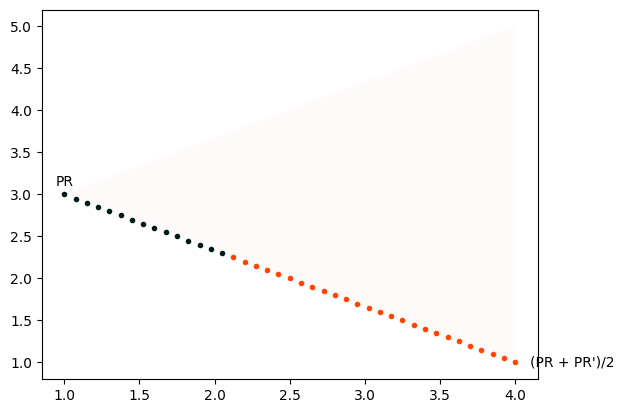

In [36]:
PR = non_local_boxes.utils.PR
PRprime = non_local_boxes.utils.P_NL(1,1,1)

# Set the number of wirings to 10 000

draw_segment_with_rerun(
    Box1=PR,
    Box1_name = "PR",
    Box2=(PR+PRprime)/2,
    Box2_name = "(PR + PR')/2",
    box_grid_size = 40,
    max_box_power_GD = 10,
    max_box_power = 35,
    learning_rate = 2,
    nb_iterations = 40,
    threshold = (3 + float(torch.sqrt(torch.tensor(6))))/6,
    rerun_count = 1
)

In [ ]:
#assert(False)

# Let's change the segment

 ----- Run number  0
0.75000006
0.75
0.75
0.75
0.75
0.75
0.75
0.75
0.75
0.75
0.7500001
0.75
0.75
0.74999994
0.7499999
0.74999976
0.74999976
0.74999964
0.75
0.75
0.7499999
0.74999994
0.7499999
0.7499999
0.75000006
0.7500001
0.7500002
0.7500002
0.7500002
0.7500002
0.7527534
0.7600316
0.7660847
0.7701706
0.77012557
0.7701516
0.7511227
0.75281984
0.7565537
0.76093906
0.76218355
0.7626379
0.75851923
0.7499391
0.75024754
0.7503336
0.7504041
0.75047606
0.7652478
0.7600309
0.7565964
0.7542112
0.75249
0.75121635
0.7805062
0.7509082
0.7499094
0.7499854
0.74999845
0.74999994
0.77553
0.76554936
0.7574682
0.75411713
0.750445
0.7487376
0.79128647
0.7958333
0.7958333
0.79583323
0.79583323
0.7958331
0.7901158
0.79430366
0.79503727
0.7950421
0.79504454
0.795047
0.7923169
0.7885662
0.7863164
0.7861284
0.78549314
0.78549314
0.80218744
0.8021874
0.80147254
0.8014725
0.8007753
0.80077523
0.7997312
0.8125
0.8125
0.8125
0.8125
0.8125
0.8201264
0.8107762
0.7828403
0.7874871
0.80289483
0.80327487
0.8183442
0.8

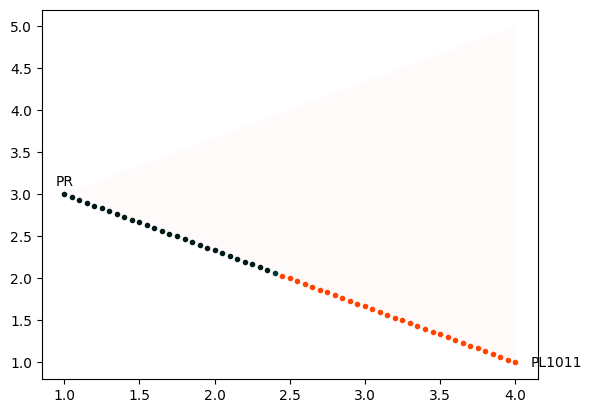

In [50]:
# Set the number of wirings to 10 000

draw_segment_with_rerun(
    Box1=non_local_boxes.utils.PR,
    Box1_name = "PR",
    Box2=non_local_boxes.utils.P_L(1,0,1,1),
    Box2_name = "PL1011",
    box_grid_size = 60,
    max_box_power_GD = 7,
    max_box_power = 45,
    learning_rate = 2,
    nb_iterations = 20,
    threshold = (3 + float(torch.sqrt(torch.tensor(6))))/6,
    rerun_count = 1
)

In [51]:
W_result = torch.tensor([0.0000, 0.0000, 0.2942, 1.0000, 1.0000, 0.0550, 0.5599, 0.0000, 0.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.0000, 0.0000, 0.0000, 1.0000,
        0.2810, 1.0000, 1.0000, 1.0000, 1.0000, 0.0000, 0.0000, 1.0000, 1.0000,
        1.0000, 0.0000, 0.0000, 0.0000, 1.0000])

0.75
0.7541667222976685
0.7583333253860474
0.762499988079071
0.7666666507720947
0.7708333730697632
0.7749999761581421
0.7791666388511658
0.7833333611488342
0.7875000238418579
0.7916666269302368
0.7958333492279053
0.800000011920929
0.8041666746139526
0.8083332777023315
0.8125
0.8166667222976685
0.8208333253860474
0.8250000476837158
0.8291666507720947
0.8333333730697632
0.8374999761581421
0.8416666984558105
0.8458333015441895
0.8500000238418579
0.8541666269302368
0.8583333492279053
0.8624999523162842
0.8666666746139526
0.8708332777023315
0.875
0.8791666030883789
0.8833333253860474
0.8875000476837158
0.8916666507720947
0.8958333134651184
0.8999999761581421
0.9041666984558105
0.9083333015441895
0.9124999642372131
0.9166666865348816
0.9208333492279053
0.9249999523162842
0.9291666746139526
0.9333333969116211
0.9375
0.9416666030883789
0.9458333253860474
0.9500000476837158
0.9541666507720947
0.9583333134651184
0.9624999761581421
0.9666666984558105
0.9708333015441895
0.9750000238418579
0.979166

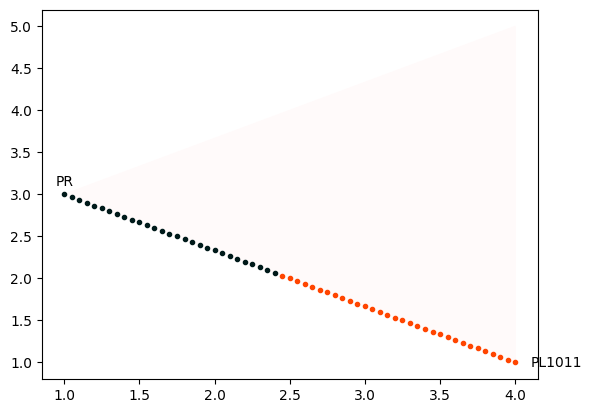

In [52]:
# Set the number of wirings to 1

test_wiring_segment(
    W = W_result,
    Box1=non_local_boxes.utils.PR,
    Box1_name = "PR",
    Box2=non_local_boxes.utils.P_L(1,0,1,1),
    Box2_name = "PL1011",
    box_grid_size = 60,
    max_box_power = 1000,
    threshold = (3 + float(torch.sqrt(torch.tensor(6))))/6
)

In [ ]:
test_wiring_triangle(
    W = W_result,
    Box1=non_local_boxes.utils.PR,
    Box1_name = "PR",
    Box2=non_local_boxes.utils.P_L(0,0,1,0),
    Box2_name = "PL0010",
    Box3=non_local_boxes.utils.P_L(0,1,1,1),
    Box3_name = "PL0111",
    box_grid_size = 60,
    max_box_power = 7,
    threshold = (3 + float(torch.sqrt(torch.tensor(6))))/6
)